In [224]:
### THIS PROJECT USES TENSORFLOW=2.15 AND KERAS=3.0.5

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np

In [2]:
face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#### Testing

In [193]:
cap=cv2.VideoCapture(0)
while True:
    ret,frame=cap.read()
    if ret:
        # cv2.rectangle(frame,(140,50),(500,400),(0,0,255),2)
        gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=3)
        # a=0,b=0,c=0,d=0
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
            # a=x,b=y,c=w,d=h
        cv2.imshow("test",frame[140:500,50:400])
        if cv2.waitKey(1) & 0xFF==ord('q'):
            break
cap.release()
cv2.destroyAllWindows()


In [190]:
cap.release()

### Data Augmentation

In [271]:
for img in os.listdir("images"):
    image=cv2.imread(os.path.join("images",img))
    name=img
    new_img=tf.image.stateless_random_flip_up_down(image,seed=(np.random.randint(100),np.random.randint(100)))
    new_img = tf.image.stateless_random_flip_left_right(new_img, seed=(np.random.randint(100),np.random.randint(100)))
    cv2.imwrite(os.path.join("images",name),new_img.numpy())

KeyboardInterrupt: 

In [5]:
for img in os.listdir("images"):
    image=cv2.imread(os.path.join("images",img))
    name=img
    new_img = tf.image.stateless_random_brightness(image, max_delta=0.02, seed=(1,2))
    new_img = tf.image.stateless_random_contrast(new_img, lower=0.6, upper=1, seed=(1,3))
    new_img = tf.image.stateless_random_jpeg_quality(new_img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
    new_img = tf.image.stateless_random_saturation(new_img, lower=0.9, upper=1, seed=(np.random.randint(100),np.random.randint(100))) 
    cv2.imwrite(os.path.join("images",name),new_img.numpy())

KeyboardInterrupt: 

In [57]:
#creating tf data pipeline
positives=tf.data.Dataset.from_tensor_slices(tf.io.gfile.glob("images/*.jpg")[:700])

In [58]:
len(positives)

700

In [65]:
negatives=tf.data.Dataset.from_tensor_slices(tf.io.gfile.glob("images/no_face/images/*.jpg"))

In [66]:
len(negatives)

700

In [67]:
positive=tf.data.Dataset.zip((positives,tf.data.Dataset.from_tensor_slices(tf.ones(len(positives)))))
negative=tf.data.Dataset.zip((negatives,tf.data.Dataset.from_tensor_slices(tf.zeros(len(negatives)))))

In [68]:
positive,negative

(<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>,
 <_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>)

In [12]:
#preprocessing image
def load_image(x):
    byte_image=tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_image)
    img=tf.image.resize(img,(200,200))
    img=img/255.0
    return img

In [69]:
data=positive.concatenate(negative)

In [70]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [71]:
sample=data.as_numpy_iterator().next()

In [72]:
sample

(b'images\\Aaron_Eckhart_0001.jpg', 1.0)

In [73]:
def preprocess(image,label):
    return(load_image(image),label)

In [74]:
res=preprocess(*sample)

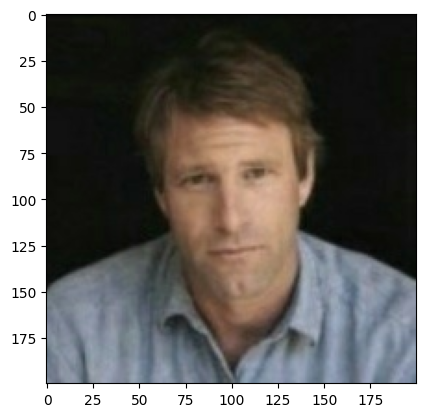

In [75]:
import matplotlib.pyplot as plt
plt.imshow(res[0])

In [76]:
#build dataloader pipeline
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=2000)
# data=data.batch(16)
# data=data.prefetch(8)

In [77]:
train=data.take(round(len(data)*.8))
train=train.batch(16)
train=train.prefetch(8)

In [78]:
val=data.skip(round(len(data)*.8))
val=data.take(round(len(data)*.2))
val=val.batch(16)
val=val.prefetch(8)

In [79]:
train,val

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### building Feature Extractor model

In [80]:
from tensorflow.keras.layers import Conv2D,Layer,Input,Dense,MaxPooling2D,Flatten,Concatenate,Normalization
from tensorflow.keras.models import Model

In [81]:
def FeatureExtractor():
    i=Input(shape=(200,200,3))
    c1=Conv2D(64,kernel_size=(7,7),strides=(2,2),activation="relu")(i)
    m1=MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")(c1)
    
    c3=Conv2D(32,kernel_size=(3,3),strides=(2,2),activation="relu")(m1)
#     d=Dropout(0.2)(c3)
    m3=MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="same")(c3)

    c4=Conv2D(32,kernel_size=(3,3),strides=(1,1),activation="relu")(c3)
#     d2=Dropout(0.2)(c4)
    f=Flatten()(m3)
    
    x=Dense(128,activation='relu',name="img_features")(f)

    return [i,x,c4]

In [82]:
def EuclideanDistance(feature1,feature2):
    return np.linalg.norm(feature1 - feature2)

In [83]:
def addLastLayer():
    i,fully_connected,_=FeatureExtractor()
    x=Dense(1,activation="sigmoid")(fully_connected)
    final_model=Model(inputs=[i],outputs=[x,fully_connected])
    final_model.build(input_shape=(200,200,3))
    return final_model

In [84]:
final_model=addLastLayer()

In [85]:
final_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 97, 97, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ img_features (Dense)                 │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 618,017 (2.36 MB)

 Trainable params: 618,017 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
loss=tf.keras.losses.BinaryCrossentropy()
accuracy=tf.keras.metrics.binary_accuracy
opt=tf.keras.optimizers.Adam(learning_rate=0.001)

In [87]:
class Attendance(Model):
    def __init__(self,model,**kwargs):
        super().__init__(**kwargs)
        self.model=model
        
    def compile(self,opt,loss,**kwargs):
        super().compile(**kwargs)
        self.loss=loss
        self.opt=opt
    
    def train_step(self,batch,**kwargs):
        X,y=batch

        with tf.GradientTape() as tape:
            yhat=self.model(X,training=True)
            classLoss=self.loss(y,yhat[0])
            grad=tape.gradient(classLoss,self.model.trainable_variables)
        opt.apply_gradients(zip(grad,self.model.trainable_variables))
        
        acc=accuracy(y,yhat[0])
        return {"loss":classLoss,"accuracy":acc}
    
    def test_step(self,batch,**kwargs):
        X,y=batch
        
        yhat=self.model(X,training=False)
        classLoss=self.loss(y,yhat[0])
        
        acc=accuracy(y,yhat[0])
        return {"loss":classLoss,"accuracy":acc}
    
    def get_config(self):
        base_config = super().get_config()
        config = {
                "submodel": tf.keras.utils.serialize_keras_object(self.model),
                }
        return {**base_config, **config}
    @classmethod
    def from_config(cls, config):
        submodel_config = config.pop("submodel")
        submodel = tf.keras.utils.deserialize_keras_object(submodel_config)
        return cls(model=submodel, **config)
    
    def call(self,X,**kwargs):
        return self.model(X,**kwargs)

In [88]:
model=Attendance(final_model)

In [89]:
model.compile(opt,loss)

In [90]:
hist=model.fit(train,epochs=18,validation_data=val)

Epoch 1/18
70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 661ms/step - accuracy: 0.6893 - loss: 0.5616 - val_loss: 0.0000e+00
Epoch 2/18
29/70 ━━━━━━━━━━━━━━━━━━━━ 24s 599ms/step - accuracy: 0.9159 - loss: 0.2471

KeyboardInterrupt: 

In [93]:
model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[array([[1.]], dtype=float32),
 array([[[[0.06995451, 0.        , 0.        , ..., 0.        ,
           0.5103444 , 0.33402634],
          [0.07154223, 0.        , 0.        , ..., 0.        ,
           0.50970376, 0.33436364],
          [0.07158598, 0.        , 0.        , ..., 0.        ,
           0.5079881 , 0.33186924],
          ...,
          [0.06170007, 0.        , 0.        , ..., 0.        ,
           0.47968766, 0.30303866],
          [0.06011868, 0.        , 0.        , ..., 0.        ,
           0.47934082, 0.3007492 ],
          [0.06021099, 0.        , 0.        , ..., 0.        ,
           0.47755685, 0.30051023]],
 
         [[0.        , 0.345288  , 0.06240192, ..., 0.        ,
           0.59418887, 0.41712418],
          [0.        , 0.3434408 , 0.05956738, ..., 0.        ,
           0.592255  , 0.4212896 ],
          [0.        , 0.3415691 , 0.06220142, ..., 0.        ,
           0.5914476 , 0.41722468],
          ...,
          [0.        , 0.30776843, 0

##### zero loss,val_loss and 1 accuracy is because every image being passed has an image and hence the label will always be 1, there is no image which has label 0 and hence the loss and accuracy are 0 and 1

In [91]:
# model.save("AttendanceSystem.keras")
# model.save_weights("model_weights.h5")

In [92]:
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'Attendance': Attendance}):
    # custom_objects = {'Attendance': Attendance.from_config}
    # custom_objects={'Functional':tf.keras.models.Model}
    model=tf.keras.models.load_model("AttendanceSystem.keras")

C:\Users\dellb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


### Manual Testing

In [64]:

# features_extracted=output[-1]

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x1f168188ee0>

In [244]:
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [46]:
test_img=os.path.join("images","Zinedine_Zidane_0001.jpg")

In [47]:
test_img

'images\\Zinedine_Zidane_0001.jpg'

In [48]:
test_img=load_image(test_img)

In [49]:
test_img=np.expand_dims(test_img,axis=0)

In [307]:
# test_img

In [51]:
feature1=model.predict(test_img)[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [52]:
feature2=model.predict(np.expand_dims(load_image(os.path.join("images","Zydrunas_Ilgauskas_0001.jpg")),axis=0))[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [310]:
person_feature={}

In [53]:
dist1=EuclideanDistance(feature1,feature2)

In [54]:
dist2=EuclideanDistance(feature1,model.predict(np.expand_dims(load_image(os.path.join("images","Zinedine_Zidane_0004.jpg")),axis=0))[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [55]:
dist1,dist2

(26.950155, 21.104065)

In [56]:
dist2<dist1

True

In [846]:
person_feature["Zach_Parise_0001"]=EuclideanDistance(feature1,feature2)

In [847]:
len(person_feature)

6

In [848]:
min_distance=min(person_feature.values())

In [851]:
person_feature.values()

dict_values([318251.4, 477340.8, 1943809.6, 854507.2, 1962109.6, 2332049.2])

In [849]:
min_distance

318251.4

In [850]:
for key in list(person_feature.keys()):
    if person_feature[key]==min_distance:
        print(key)
        break

Zinedine_Zidane_0002


In [852]:
person_feature.keys()

dict_keys(['Zinedine_Zidane_0002', 'Zydrunas_Ilgauskas_0001', 'Zoe_Ball_0001', 'Zico_0001', 'Yuri_Malenchenko_0001', 'Zach_Parise_0001'])

### Realtime Comparison

In [292]:
def isFace(gray,frame):
    faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=3)
    if len(faces)>0:
        return (True,faces)
    else:
        return(False,faces)

In [293]:
def NewFace():
    cap=cv2.VideoCapture(0)
    try:
        while True:
            ret,frame=cap.read()
            if ret:
                # cv2.rectangle(frame,(140,50),(500,400),(0,0,255),2)
                gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                face,coord=isFace(gray,frame)
                # print(coord)
                if face:
                    for (x,y,w,h) in coord:
                        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
                cv2.imshow("test",frame)
                key=cv2.waitKey(1) & 0xFF
                if face and key==ord('c'):
                    name=input("Enter name: ")
                    print("processing..")
                    imgpath=os.path.join("user_imgs",name+".jpg")
                    cv2.imwrite(imgpath,frame[coord[0][1]:coord[0][1]+coord[0][3],coord[0][0]:coord[0][0]+coord[0][2]])
                    frame=np.expand_dims(load_image(imgpath),axis=0)
                    features=model.predict(frame)[1]
                    np.save("features/"+name+".npy",features)
                    print("done")
                    cap.release()
                    cv2.destroyAllWindows()
                    return
                elif key==ord('q'):
                    break
    except Exception as e:
        print(e,frame.shape)
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [319]:
NewFace()

Enter name:  deepak


processing..
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
done


In [296]:
feature_test=np.load("features/arnav.npy")

In [300]:
print(feature_test)

[[0. 0. 0. ... 0. 0. 0.]]


In [298]:
def SameFaceCheck():
    cap=cv2.VideoCapture(0)
    try:
        while True:
            ret,frame=cap.read()
            if ret:
                gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
                face,coord=isFace(gray,frame)
                if face:
                    for (x,y,w,h) in coord:
                        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
                cv2.imshow("test",frame)
                key=cv2.waitKey(1) & 0xFF
                if face and key==ord('a'):
                    print("processing..")
                    imgpath=os.path.join("user_imgs","temp"+".jpg")
                    cv2.imwrite(imgpath,frame[coord[0][1]:coord[0][1]+coord[0][3],coord[0][0]:coord[0][0]+coord[0][2]])
                    img=np.expand_dims(load_image(imgpath),axis=0)
                    new=model.predict(img)[1]
                    person_feature={}
                    for feature in os.listdir("features"):
                        present=np.load("features/"+feature)
                        distance=EuclideanDistance(present,new)
                        person_feature[distance]=feature
                    min_dist=min(person_feature.keys())
                    print(person_feature[min_dist][:-4])
                    os.remove(os.path.join("user_imgs","temp.jpg"))
                    cap.release()
                    cv2.destroyAllWindows()
                    return
                elif key==ord('q'):
                    break
    except Exception as e:
        print(e)
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [322]:
SameFaceCheck()

processing..
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
devesh
